<a href="https://colab.research.google.com/github/Grubes2023/403_team_29/blob/main/Disaster_model_v0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# import the required libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from keras.optimizers import Adam, RMSprop
from keras.models import Model
from keras.layers import Embedding, LSTM, Dense, Dropout, Input, Activation
from keras.callbacks import EarlyStopping
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer

In [ ]:
# nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
# stop_words = set(stopwords.words('english'))

In [4]:
#creating a function to prepocess tweet
def data_processing(tweet):
    tweet = tweet.lower()                                                         # Make tweet lowercase for consistency
    tweet = re.sub(r"https\S+|www\S+http\S+", '', tweet, flags = re.MULTILINE)    # get rid of any websites in tweet

    tweet = re.sub(r'\@w+|\#','', tweet)                                        
    tweet = re.sub(r'[^\w\s]','',tweet)
    tweet = re.sub(r'ð','',tweet)  
    return tweet

# time to get the stem (lemma) of each word in the tweet
lemmatizer = WordNetLemmatizer()
def lemmatizing(data):
    # split string into list of words
    word_list = data.split()
    # lemmatize each word in the list
    word_list = [lemmatizer.lemmatize(word) for word in word_list]
    # combine the list into 1 string and return that string
    tweet = ' '.join(word_list)
    return tweet

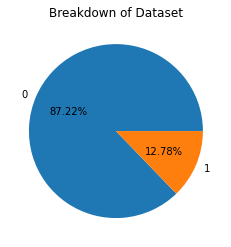

In [6]:
tweet_df = pd.read_csv('disaster_training_binary.csv')

# apply proprocessing function to tweets and save as itself
tweet_df.tweet = tweet_df['tweet'].astype(str)
tweet_df.tweet = tweet_df['tweet'].apply(data_processing)
# get rid of any duplicate tweets and save as itself
tweet_df = tweet_df.drop_duplicates('tweet')

tweet_df.tweet = tweet_df['tweet'].apply(lambda x: lemmatizing(x))    # apply lemmatizer

## up and downsampling tweets
class_1 = tweet_df[tweet_df['label'] == 1]
class_0 = tweet_df[tweet_df['label'] == 0]  #.sample(n=1000)
# print(class_0.shape)
# print(class_1.shape)

balanced_df = pd.concat([class_1, class_0], axis=0)

# getting data into training and testing sets
features = balanced_df['tweet']
labels = balanced_df['label']
X_train, X_val, Y_train, Y_val = train_test_split(features,
                                                  labels,
                                                  test_size=0.1,
                                                  random_state=42)

# Visualizing the Data
plt.pie(balanced_df['label'].value_counts().values,
        labels = balanced_df['label'].value_counts().index.astype(int),
        autopct='%1.2f%%',
        wedgeprops = {'linewidth': 1})
plt.title('Breakdown of Dataset')
plt.show()

In [7]:
## My model parameters
VOCAB_SIZE = 6400
MAX_LEN = 250

tok = Tokenizer(num_words=VOCAB_SIZE)
tok.fit_on_texts(X_train)

sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences, maxlen=MAX_LEN)

val_sequences = tok.texts_to_sequences(X_val)
val_sequences_matrix = pad_sequences(val_sequences, maxlen=MAX_LEN)

### MODEL
def RNN():
    inputs = Input(name='inputs',shape=[MAX_LEN])
    layer = Embedding(VOCAB_SIZE,50,input_length=MAX_LEN)(inputs)

    # adding a Long-Short term memory layer. This is kinda the NLP part of model
    layer = LSTM(512)(layer)

    # adding a dense/activation/dropout layer
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)

    # adding a second dense/activation/dropout layer
    layer = Dense(512,name='FC2')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.25)(layer)

    # adding the final output layer
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)

    model = Model(inputs=inputs,outputs=layer)
    return model

model = RNN()
model.summary()
my_optimizer = Adam()
model.compile(loss='binary_crossentropy',optimizer=my_optimizer, metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 250)]             0         
                                                                 
 embedding (Embedding)       (None, 250, 50)           320000    
                                                                 
 lstm (LSTM)                 (None, 512)               1153024   
                                                                 
 FC1 (Dense)                 (None, 256)               131328    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 FC2 (Dense)                 (None, 512)               131584

In [31]:
callback = EarlyStopping(monitor='loss', min_delta=0.0001, start_from_epoch=4, mode='max', restore_best_weights=True, patience=2)

model.fit(sequences_matrix,Y_train,batch_size=128,epochs=8,
          validation_data=(val_sequences_matrix, Y_val), verbose=1,callbacks=[callback])

Epoch 1/8
39/39 [==============================] - 3s 85ms/step - loss: 0.0138 - accuracy: 0.9956 - val_loss: 0.3787 - val_accuracy: 0.9260
Epoch 2/8
39/39 [==============================] - 3s 82ms/step - loss: 0.0298 - accuracy: 0.9908 - val_loss: 0.3371 - val_accuracy: 0.8791
Epoch 3/8
39/39 [==============================] - 3s 81ms/step - loss: 0.0459 - accuracy: 0.9831 - val_loss: 0.3598 - val_accuracy: 0.9224
Epoch 4/8
39/39 [==============================] - 3s 82ms/step - loss: 0.0098 - accuracy: 0.9968 - val_loss: 0.3835 - val_accuracy: 0.9224
Epoch 5/8
39/39 [==============================] - 3s 83ms/step - loss: 0.0030 - accuracy: 0.9994 - val_loss: 0.4434 - val_accuracy: 0.9278
Epoch 6/8
39/39 [==============================] - 3s 81ms/step - loss: 0.0024 - accuracy: 0.9996 - val_loss: 0.4694 - val_accuracy: 0.9296
Epoch 7/8
39/39 [==============================] - 3s 82ms/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.5189 - val_accuracy: 0.9224


In [33]:
test_tweets =[
              ["a semi truck crashed on the highway",0],
              ["Love the new bbq pit. Gets good and hot, and smokes brisket like no other",0],
              ["the fire near the power plant is hot", 1],
              ["heavy winds on the way to dallas", 1], 
              ["incoming rain", 0],
              ["this concert is fire", 0],
              ["a violent storm is coming into town", 0],
             ]

# NOTES FROM TESTING
"""
need to break connection between 'BREAKING' and label 1
need some example of rain in label 0
need some highway crash examples in label 0
need something to connect disaster near a power plant to label 1/2
need some more violent storm examples of label 1
"""

new_tweets = []
true_labels = []
pred_preds = []
for i in range(len(test_tweets)):
    new_tweets.append(test_tweets[i][0])
    true_labels.append(test_tweets[i][1])

seq = tok.texts_to_sequences(new_tweets)
padded = pad_sequences(seq, maxlen=MAX_LEN)
pred = model.predict(padded).squeeze()

categories = {0 : "No Concern",
              1 : "Of Moderate Concern",
              2 : "An Immediate Threat"}

for i in range(len(new_tweets)):
    print(new_tweets[i])
    print("Raw Output of Model : ", np.around(pred[i], decimals=3))
    prediction = np.around(pred[i]).astype(int)
    pred_preds.append(prediction)
    print("Predicted: ", categories[prediction], '\n')

1/1 [==============================] - 0s 36ms/step
a semi truck crashed on the highway
Raw Output of Model :  0.738
Predicted:  Of Moderate Concern 

Love the new bbq pit. Gets good and hot, and smokes brisket like no other
Raw Output of Model :  0.0
Predicted:  No Concern 

the fire near the power plant is hot
Raw Output of Model :  0.016
Predicted:  No Concern 

heavy winds on the way to dallas
Raw Output of Model :  0.996
Predicted:  Of Moderate Concern 

incoming rain
Raw Output of Model :  0.042
Predicted:  No Concern 

this concert is fire
Raw Output of Model :  0.0
Predicted:  No Concern 

a violent storm is coming into town
Raw Output of Model :  0.15
Predicted:  No Concern 



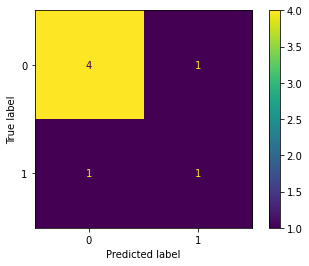

In [34]:
ConfusionMatrixDisplay(confusion_matrix(true_labels, pred_preds)).plot()
